In [1]:
import torch
import cv2
import glob
import numpy as np
import ultralytics
import matplotlib.pyplot as plt
import yolo_utils
from tqdm import tqdm

## 1. Prepare yolo detection result

1. use yolo to detect
2. assign labels : 0-invalid, 1-front, 2-left, 3-right

In [88]:
script_module = torch.jit.load("../models/yolo/yolov8n.torchscript")

params = sum([np.prod(p.size()) for p in script_module.parameters()])
print("# model parameters : ", params)

# model parameters :  3151904


In [3]:
save_path = "/home/yeliu/Development/LidarMapping/data/car_data_yolo"
image_paths = glob.glob("/home/yeliu/Development/LidarMapping/data/car_data/*/*.jpg")
image_paths.sort()

In [13]:
def process_image(image_path, save_path):
    image_name = image_path.split('/')[-1].split('.')[0]
    
    image_raw = cv2.imread(image_path)
    image = yolo_utils.load_image(image_raw)
    result = script_module(image)
    preds = ultralytics.utils.ops.non_max_suppression(result)[0]
    
    sub_images = yolo_utils.get_label_blocks(image_raw, preds)
    # save the sub images
    for i in range(len(sub_images)):
        save_image_path = save_path + "/" + image_name + "_" + str(i) + ".jpg"
        cv2.imwrite(save_image_path, sub_images[i])

In [15]:
for i in tqdm(range(len(image_paths))):
    process_image(image_paths[i], save_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8076/8076 [10:14<00:00, 13.15it/s]


## 2. use opencv GUI to assign label

previous made data : https://drive.google.com/file/d/1LXySVDp_BIV4KN-aEpeDeBRhsp6F4we6/view?usp=sharing

In [11]:
botton_size = 60
botton_height = 50
margin = 10
label_bottons = [
    [0, botton_size, 0, "invalid"],
    [botton_size + margin, 2 * botton_size + margin, 1, "front"],
    [2 * botton_size + 2 * margin, 3 * botton_size + 2 * margin, 2, "left"],
    [3 * botton_size + 3 * margin, 4 * botton_size + 3 * margin, 3, "right"],
    [4 * botton_size + 4 * margin, 5 * botton_size + 4 * margin, 4, "center"]
]

In [31]:
import shutil
import os
block_images_path = "/home/yeliu/Development/LidarMapping/data/car_data_yolo"
save_mm_path = "/home/yeliu/Development/ace/data/car_det"
os.mkdir(save_mm_path + "/0") 
os.mkdir(save_mm_path + "/1") 
os.mkdir(save_mm_path + "/2") 
os.mkdir(save_mm_path + "/3") 
os.mkdir(save_mm_path + "/4") 


label_images = glob.glob(block_images_path + "/*.jpg")
label_images.sort()

In [ ]:
current_idx = -1
    
def draw_image_gui(image_raw):
    # resize image_raw
    image_raw = cv2.resize(image_raw, (480, 480))
    
    shape_raw = image_raw.shape
    image_draw = np.zeros((shape_raw[0] + botton_height + 30, shape_raw[1], shape_raw[2]), np.uint8)
    image_draw[botton_height + 30:, :, :] = image_raw
    
    for i in range(len(label_bottons)):
        botton = label_bottons[i]
        cv2.rectangle(image_draw,(botton[0],0),(botton[1],botton_height),(0,255,0),-1)
        cv2.putText(image_draw, botton[3],
                    (botton[0], int(botton_height * 0.5)), cv2.FONT_HERSHEY_SIMPLEX ,
                    0.7, (255, 0, 255), 2, cv2.LINE_AA)
            
    cv2.rectangle(image_draw,(400,0),(480,botton_height),(0,0,255),-1)
    
    cv2.putText(image_draw, str(current_idx)+"/"+str(len(label_images)),
                (0, botton_height + 20), cv2.FONT_HERSHEY_SIMPLEX ,
                0.5, (200, 200, 0), 2, cv2.LINE_AA)
    
    return image_draw


def update_image(current_idx):
    current_idx = current_idx + 1
    image_raw = cv2.imread(label_images[current_idx])
    image_gui = draw_image_gui(image_raw)
    return image_gui, current_idx

current_idx = 3600
image_gui, current_idx = update_image(current_idx)

# mouse callback function
def save_image(event,x,y,flags,param):
    global image_gui, current_idx
    if event != cv2.EVENT_LBUTTONDOWN:
        return
    if y > botton_height:
        return
    for i in range(len(label_bottons)):
        botton = label_bottons[i]
        if x > botton[0] and x < botton[1]:
            cv2.rectangle(image_gui,(botton[0],0),(botton[1],botton_height),(0,100,0),-1)
            # save the image
            image_name = label_images[current_idx].split('/')[-1].split('.')[0]
            save_file = save_mm_path + "/" + str(botton[2]) + "/" + image_name + ".jpg"
            shutil.copyfile(label_images[current_idx], save_file)
            # next image
            image_gui, current_idx = update_image(current_idx)
            
    if x > 400 and x < 480:
        # next image
        image_gui, current_idx = update_image(current_idx)
        
    
        
cv2.namedWindow('yolo_blocks')
cv2.setMouseCallback('yolo_blocks', save_image)

while(1):
    cv2.imshow('yolo_blocks', image_gui)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('q'):
        break

cv2.destroyAllWindows()

### 2.1 data augmentation

In [100]:
left_image_paths = glob.glob("/home/yeliu/Development/ace/data/car_det/2/*.jpg")
right_image_paths = glob.glob("/home/yeliu/Development/ace/data/car_det/3/*.jpg")

In [98]:
# data agumentation left <-> right
for left_path in left_image_paths:
    name = left_path.split('/')[-1]
    image = cv2.imread(left_path)
    image = cv2.flip(image, 1) 
    cv2.imwrite("/home/yeliu/Development/ace/data/car_det/3/" + name, image)

for right_path in right_image_paths:
    name = right_path.split('/')[-1]
    image = cv2.imread(right_path)
    image = cv2.flip(image, 1) 
    cv2.imwrite("/home/yeliu/Development/ace/data/car_det/2/" + name, image)

## 3. Classification Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CarLocClassNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(13456, 1024)
        self.fc2 = nn.Linear(1024, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [3]:
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Resize((128, 128))])

dataset = ImageFolder("/home/yeliu/Development/ace/data/car_det", transform) # adding transform to the dataset

# splitting training and testing sets
batch_size = 32
indices = list(range(len(dataset)))
random.shuffle(indices)
split_point = int(0.85*len(indices))
train_indices = indices[:split_point]
test_indices = indices[split_point:]
print("Size of the training set:", len(train_indices))
print("Size of the  testing set:", len(test_indices))

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))

Size of the training set: 3296
Size of the  testing set: 582


In [5]:
model_class = CarLocClassNet().to("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_class.parameters(), lr=0.001, momentum=0.9)

best_test = 1e6
running_losses = []
test_losses = []

In [6]:
# load the network
model_class.load_state_dict(torch.load("../models/model_class_final.pt"))

<All keys matched successfully>

In [77]:
def test_classification(model_class, test_loader):
    error_total = 0
    error_chair_view = 0
    wrong_inputs = None
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        labels_np = labels.detach().numpy()
        outputs = model_class(inputs.to('cuda'))
        labels_det = torch.argmax(outputs, dim=1).cpu()
        
        error = (labels_det - labels).detach().numpy()
        error[error != 0] = 1
        error_total += error.sum()
        
        if error.sum() > 0:
            inputs_np = inputs.cpu().detach().numpy()
            inputs_error = inputs_np[error != 0]
            if wrong_inputs is None:
                wrong_inputs = inputs_error
            else :
                wrong_inputs = np.concatenate((wrong_inputs, inputs_error), axis=0)
        
        invalid_flag = labels_np == 0
        center_flag = labels_np == 4
        error[invalid_flag] = 0
        error[center_flag] = 0
        error_chair_view += error.sum()
        
    error_total /= (batch_size * len(test_loader))
    error_chair_view /= (batch_size * len(test_loader))
    return error_total, error_chair_view, wrong_inputs

[    1] train loss: 0.013, test loss: 0.039, 0.015
[    2] train loss: 0.014, test loss: 0.043, 0.016
[    3] train loss: 0.012, test loss: 0.041, 0.013
[    4] train loss: 0.007, test loss: 0.041, 0.013
[    5] train loss: 0.012, test loss: 0.041, 0.013
[    6] train loss: 0.009, test loss: 0.044, 0.020
[    7] train loss: 0.014, test loss: 0.041, 0.015
[    8] train loss: 0.010, test loss: 0.039, 0.018
[    9] train loss: 0.010, test loss: 0.041, 0.015
[   10] train loss: 0.009, test loss: 0.048, 0.023
Finished Training


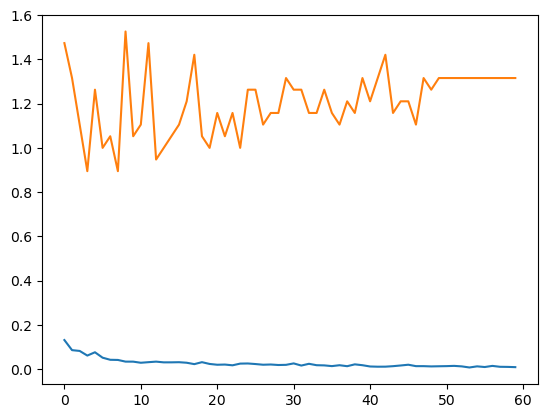

In [49]:
num_epoches = 10
for epoch in range(num_epoches):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_class(inputs.to('cuda'))
        loss = criterion(outputs, labels.to('cuda'))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    with torch.no_grad():
        terr_total, terr_chair, _ = test_classification(model_class, test_loader)
        
    running_loss /= len(train_loader)
    running_losses.append(running_loss)
    test_losses.append(terr_total)
    print(f'[{epoch + 1 : 5d}] train loss: {running_loss:.3f}, test loss: {terr_total:.3f}, {terr_chair:.3f}')
    
    if terr_total < best_test:
        best_test = terr_total
        torch.save(model_class.state_dict(), "../models/model_class.pt")

torch.save(model_class.state_dict(), "../models/model_class_final.pt")
print('Finished Training')

plt.figure()
plt.plot(running_losses)
plt.plot(test_losses)
plt.show()

### 3.1 check the test fail cases

In [91]:
params = sum([np.prod(p.size()) for p in model_class.parameters()])
print("# model parameters : ", params)

# https://github.com/sovrasov/flops-counter.pytorch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model_class, (1, 128, 128), as_strings=True,
                                             print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))


print("Computational complexity(yolo): 4.42 GMac")

# model parameters :  13869065
CarLocClassNet(
  13.87 M, 100.000% Params, 24.54 MMac, 98.819% MACs, 
  (conv1): Conv2d(156, 0.001% Params, 2.4 MMac, 9.660% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(0, 0.000% Params, 146.08 KMac, 0.588% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2.42 k, 0.017% Params, 8.13 MMac, 32.730% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(13.78 M, 99.358% Params, 13.78 MMac, 55.493% MACs, in_features=13456, out_features=1024, bias=True)
  (fc2): Linear(86.1 k, 0.621% Params, 86.1 KMac, 0.347% MACs, in_features=1024, out_features=84, bias=True)
  (fc3): Linear(425, 0.003% Params, 425.0 Mac, 0.002% MACs, in_features=84, out_features=5, bias=True)
)
Computational complexity:       24.83 MMac
Number of parameters:           13.87 M 
Computational complexity(yolo): 4.42 GMac


In [84]:
a, b, failed_cases = test_classification(model_class, test_loader)
print(a, b, failed_cases.shape)

0.047697368421052634 0.023026315789473683 (29, 1, 128, 128)


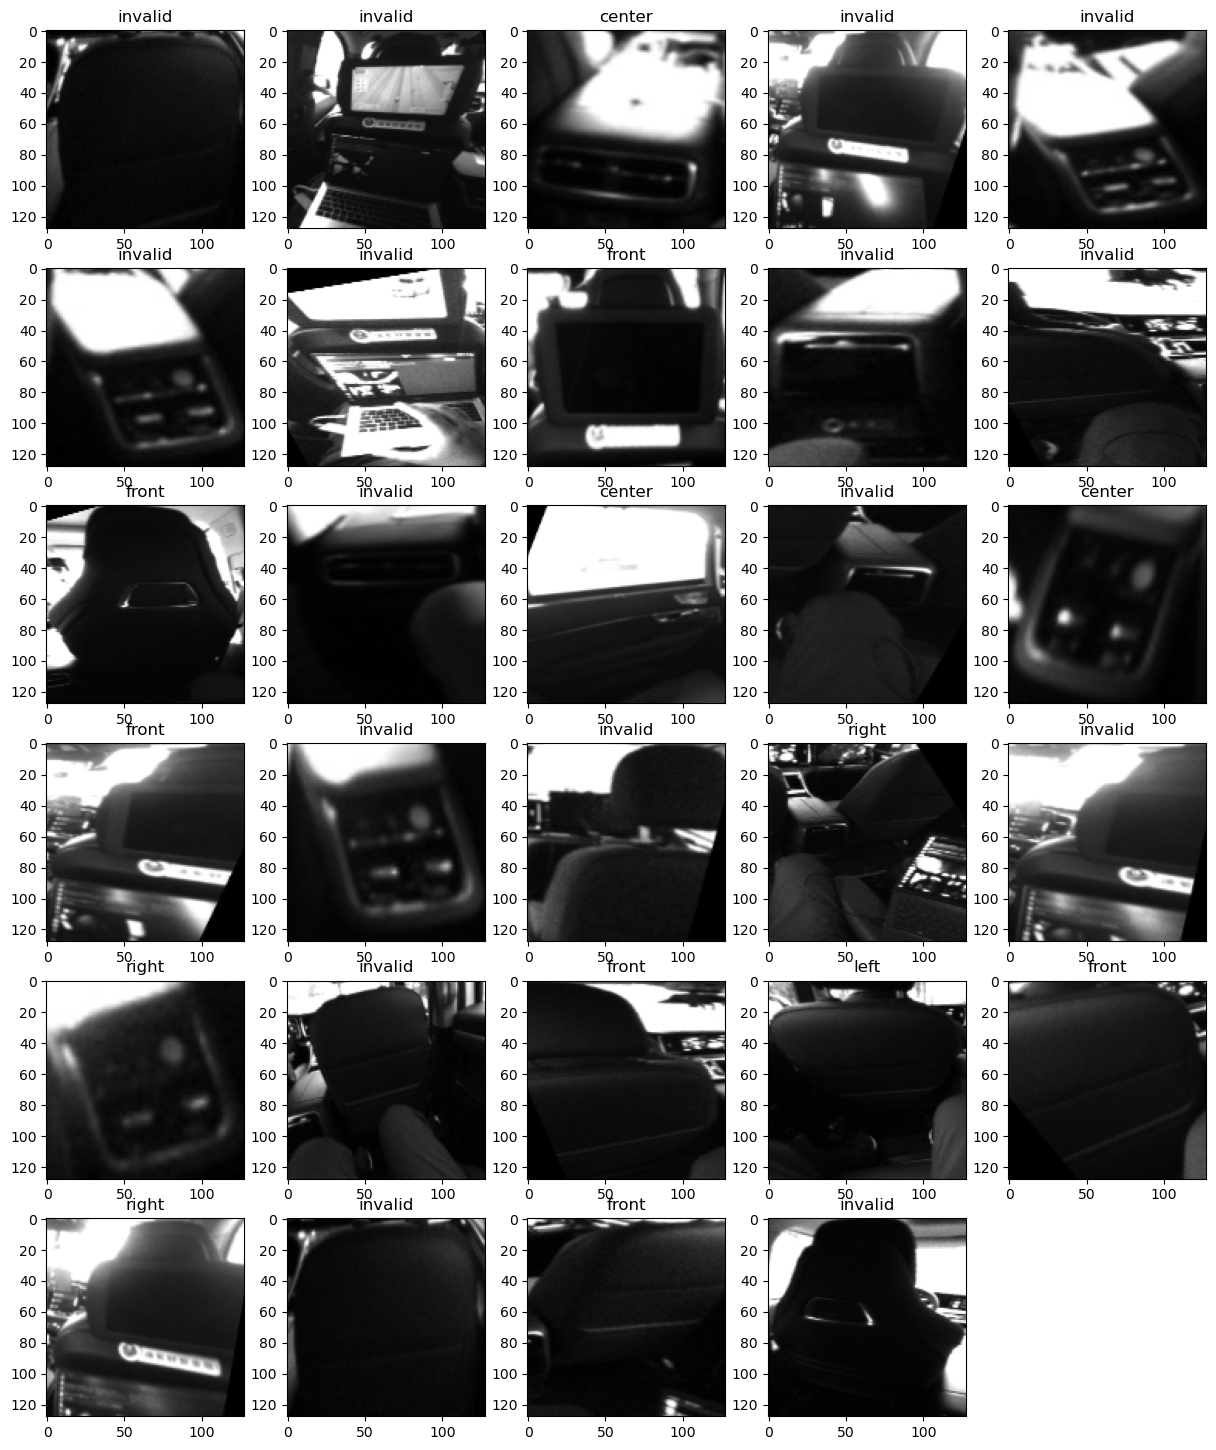

In [79]:
# plot the failed cases result
num_failed = failed_cases.shape[0]
outputs = model_class(torch.from_numpy(failed_cases).to('cuda'))
label_id = torch.argmax(outputs, axis = 1)


num_cols = 5
num_rows = int(np.ceil(num_failed / num_cols))

plt.figure(figsize=(3 * num_cols, 3 * num_rows))
for i in range(num_failed):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(failed_cases[i, 0], cmap='gray')
    plt.title(label_bottons[label_id[i]][3])

## 4. Model to SNPE

In [81]:
random_input = torch.randn(1, 1, 128, 128, requires_grad=True).cuda()

# Export the model
torch.onnx.export(model_class,               # model being run
                  random_input,              # model input (or a tuple for multiple inputs)
                  "../models/model_class.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                 )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



#### snpe 2.10
```
conda activate py36
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/yeliu/anaconda3/envs/py36/lib
export ANDROID_NDK_ROOT=/opt/android-sdk/ndk
SNPE_PATH=/home/yeliu/Downloads/dep/snpe-2.10.0.4541
source ${SNPE_PATH}/bin/envsetup.sh -p /home/yeliu/anaconda3/envs/py36/lib/python3.6/site-packages/torch
```

```
snpe-onnx-to-dlc --input_network models/model_class.onnx \
                 --output_path models/model_class_onnx.dlc
```

```
snpe-dlc-info -i models/model_class_onnx.dlc
```

#### snpe 1.6

```
conda activate py36
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/yeliu/anaconda3/envs/py36/lib
export ANDROID_NDK_ROOT=/opt/android-sdk/ndk
SNPE_PATH=/home/yeliu/Downloads/dep/snpe-1.61.0.3358
source ${SNPE_PATH}/bin/envsetup.sh -p /home/yeliu/anaconda3/envs/py36/lib/python3.6/site-packages/torch
```

```
snpe-onnx-to-dlc --input_network models/model_class.onnx \
                 --output_path models/model_class_onnx_16.dlc
```

```
snpe-dlc-info -i models/model_class_onnx_16.dlc
```

In [95]:
image_paths = glob.glob("/home/yeliu/Development/LidarMapping/data/quantize/*.jpg")

f = open("../data/image_file_list_class.txt", "w")
for path in image_paths:
    image = cv2.imread(path)[0, :, :]
    image = cv2.resize(image, (128, 128)).astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)

    path_np = path.split('.')[0] + "_class.npy"
    image.tofile(path_np)
    f.write(path_np)
    f.write("\n")
f.close()

#### snpe 2.10

```
snpe-dlc-quantize --input_dlc models/model_class_onnx.dlc \
                  --input_list data/image_file_list_class.txt \
                  --output_dlc models/model_class_onnx_quantized.dlc \
                  --axis_quant --use_enhanced_quantizer
```

```
snpe-dlc-info -i models/model_class_onnx_quantized.dlc
```

#### snpe 1.6

```
snpe-dlc-quantize --input_dlc models/model_class_onnx_16.dlc \
                  --input_list data/image_file_list_class.txt \
                  --output_dlc models/model_class_onnx_16_quantized.dlc \
                  --axis_quant --use_enhanced_quantizer
```

```
snpe-dlc-info -i models/model_class_onnx_16_quantized.dlc
```